# Autores: 
**Gabriel Roberto (221020870) e Jean Soares (241033810)**

In [2]:
from d2l import tensorflow as d2l
import requests
import tarfile
import re
import collections
import pandas as pd
from nltk.translate import IBMModel1
from nltk.translate.bleu_score import sentence_bleu


2025-01-26 22:50:53.841717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 22:50:57.320789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def baixar_arquivo(url, endereco):
    resposta = requests.get(url)
    if resposta.status_code == requests.codes.OK:
        with open(endereco, 'wb') as novo_arquivo:
                novo_arquivo.write(resposta.content)
        print("Download finalizado. Arquivo salvo em: {}".format(endereco))
    else:
        resposta.raise_for_status()

In [3]:
URL_arquivo = 'https://www.statmt.org/europarl/v7/pt-en.tgz'

baixar_arquivo(URL_arquivo, './raw_dataset.tgz')

Download finalizado. Arquivo salvo em: ./raw_dataset.tgz


In [4]:
# Caminho para o arquivo .tgz
caminho_arquivo = './raw_dataset.tgz'

# Abrir o arquivo .tgz
with tarfile.open(caminho_arquivo, 'r:gz') as arquivo_tgz:
    # Extrair todos os arquivos do .tgz
    arquivo_tgz.extractall(path='./')

    # Listar os arquivos extraídos
    for membro in arquivo_tgz.getmembers():
        print(membro.name)

europarl-v7.pt-en.en
europarl-v7.pt-en.pt


# Leitura do Dataset

In [5]:
class ParallelCorpus(d2l.DataModule):
    """The Parallel Corpus Portuguese-English dataset."""
    def _download(self, fname):
        with open(fname) as f:
            return f.read()

In [6]:
data = ParallelCorpus()
raw_text_en = data._download('./europarl-v7.pt-en.en')
raw_text_en[:60]

'Resumption of the session\nI declare resumed the session of t'

In [7]:
raw_text_pt = data._download('./europarl-v7.pt-en.pt')
raw_text_pt[:60]

'Reinício da sessão\nDeclaro reaberta a sessão do Parlamento E'

In [8]:
@d2l.add_to_class(ParallelCorpus)
def _preprocess(self, text):
    return re.sub(r'[^\w\s]', '', text).lower()

In [10]:
text_en = data._preprocess(raw_text_en)

# Removendo dez mil senteças para facilitar o processamento
text_en = ' '.join(text_en.split()[:10000])

text_en[:60]

'resumption of the session i declare resumed the session of t'

In [11]:
text_pt = data._preprocess(raw_text_pt)

# Removendo dez mil senteça para facilitar o processamento
text_pt = ' '.join(text_pt.split()[:10000])

text_pt[:60]

'reinício da sessão declaro reaberta a sessão do parlamento e'

# Tokenização

In [12]:
source_sentences = text_en.split()
target_sentences = text_pt.split()

print(len(source_sentences), len(target_sentences))

10000 10000


In [13]:
def preprocess2(text):
  return re.sub(r'[^a-z]+', ' ', text).split()

def get_diff_words(text):
  set_words = set()
  text_list = preprocess2(text)

  for word in text_list:
    set_words.add(word)

  return set_words

In [14]:
text_en_diff = get_diff_words(text_en)
text_en_diff

{'addition',
 'd',
 'prepared',
 'ill',
 'status',
 'lorries',
 'imagine',
 'fiveyear',
 'internationally',
 'ppe',
 'terribly',
 'specifically',
 'myself',
 'comitology',
 'pass',
 'their',
 'five',
 'failure',
 'military',
 'believes',
 'commissions',
 'march',
 'laws',
 'whenever',
 'thanks',
 'bomb',
 'document',
 'wide',
 'governments',
 'get',
 'scant',
 'urge',
 'peaceful',
 'supervisory',
 'was',
 'hand',
 'presently',
 'employment',
 'districts',
 'months',
 'fellow',
 'frost',
 'today',
 'ad',
 'stands',
 'expected',
 'running',
 'rejection',
 'ourselves',
 'feel',
 'taken',
 'courts',
 'st',
 'pleased',
 'labour',
 'socialists',
 'experience',
 'type',
 'convenient',
 'addressed',
 'am',
 'properly',
 'policy',
 'comment',
 'needless',
 'sums',
 'original',
 'instead',
 'discuss',
 'internal',
 'tool',
 'firstly',
 'next',
 'look',
 'subvert',
 'modest',
 'wishes',
 'lynne',
 'changeover',
 'discussing',
 'rich',
 'prerequisites',
 'check',
 'approximation',
 'spanish',
 'eq

In [15]:
@d2l.add_to_class(ParallelCorpus)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text_en)
','.join(tokens[:30])

'r,e,s,u,m,p,t,i,o,n, ,o,f, ,t,h,e, ,s,e,s,s,i,o,n, ,i, ,d,e'

# Vocabulário

In [16]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [17]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [29, 16, 30, 32, 24, 27, 31, 20, 26, 25]
words: ['r', 'e', 's', 'u', 'm', 'p', 't', 'i', 'o', 'n']


# Definindo o Modelo

In [19]:
@d2l.add_to_class(ParallelCorpus)
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text_en)
len(corpus), len(vocab)

(289559458, 180)

In [20]:
words = text_en.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 736),
 ('of', 361),
 ('to', 343),
 ('and', 231),
 ('in', 229),
 ('that', 186),
 ('is', 179),
 ('a', 176),
 ('this', 163),
 ('i', 144)]

In [21]:
vocab.token_freqs[:50]

[('the', 736),
 ('of', 361),
 ('to', 343),
 ('and', 231),
 ('in', 229),
 ('that', 186),
 ('is', 179),
 ('a', 176),
 ('this', 163),
 ('i', 144),
 ('we', 140),
 ('on', 135),
 ('for', 123),
 ('it', 96),
 ('which', 87),
 ('have', 85),
 ('be', 85),
 ('as', 82),
 ('would', 77),
 ('not', 74),
 ('commission', 69),
 ('with', 67),
 ('has', 57),
 ('are', 56),
 ('by', 55),
 ('mr', 54),
 ('president', 53),
 ('like', 51),
 ('been', 50),
 ('safety', 45),
 ('parliament', 44),
 ('you', 42),
 ('transport', 42),
 ('should', 40),
 ('also', 40),
 ('will', 37),
 ('european', 36),
 ('there', 34),
 ('but', 34),
 ('all', 33),
 ('madam', 30),
 ('at', 30),
 ('very', 29),
 ('do', 29),
 ('my', 29),
 ('group', 29),
 ('so', 28),
 ('s', 27),
 ('an', 27),
 ('goods', 27)]

In [22]:
source_sentences = text_en.split()
target_sentences = text_pt.split()

print(len(source_sentences), len(target_sentences))

10000 10000


In [23]:
from nltk import AlignedSent

bitext = []
bitext.append(AlignedSent(source_sentences, target_sentences))
ibm_model = IBMModel1(bitext, 5)  # 5 iterations for training


## Codificador-Decodificador

In [28]:
import tensorflow as tf

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)

    def call(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(tf.transpose(X))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [29]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = tf.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

2025-01-27 00:11:44.760139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-27 00:11:44.914842: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [30]:
d2l.check_len(enc_state, num_layers)
d2l.check_shape(enc_state[0], (batch_size, num_hiddens))

In [31]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(num_hiddens, num_layers, dropout)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def call(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(tf.transpose(X))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = tf.tile(tf.expand_dims(context, 0), (embs.shape[0], 1, 1))
        # Concat at the feature dimension
        embs_and_context = tf.concat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = tf.transpose(self.dense(outputs), (1, 0, 2))
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [32]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_len(state[1], num_layers)
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

In [33]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return tf.keras.optimizers.Adam(learning_rate=self.lr)

In [34]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = tf.cast(tf.reshape(Y, -1) != self.tgt_pad, tf.float32)
    return tf.reduce_sum(l * mask) / tf.reduce_sum(mask)

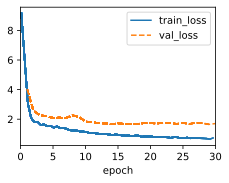

In [40]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
with d2l.try_gpu():
    encoder = Seq2SeqEncoder(
        len(source_sentences), embed_size, num_hiddens, num_layers, dropout)
    decoder = Seq2SeqDecoder(
        len(target_sentences), embed_size, num_hiddens, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, tgt_pad=vocab['<pad>'], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

In [41]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len, training=False)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tf.expand_dims(tgt[:, 0], 1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state, training=False)
        outputs.append(tf.argmax(Y, 2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return tf.concat(outputs[1:], 1), attention_weights

In [46]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
ports = ['vai .', 'eu perdi .', 'ele está calmo .', 'estou em casa .']
preds, _ = model.predict_step(
    data.build(engs, ports), d2l.try_gpu(), data.num_steps)
for en, pt, p in zip(engs, ports, preds):
    translation = []
    for token in vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{sentence_bleu([pt.split()], translation, weights=(1, 0, 0, 0))}')

go . => ['158', '1', '143', '15', '15', '15', '15', '15', '15'], bleu,0
i lost . => ['after', 'arrangement', '158', '12', '143', '15', '15', '15', '15'], bleu,0
he's calm . => ['although', '158', '12', '143', '15', '15', '15', '15', '15'], bleu,0
i'm home . => ['after', 'arrangement', '158', '12', '143', '15', '15', '15', '15'], bleu,0
